In [1]:
!pip install torchinfo

### Import Libraries

In [2]:
import time
import os
import pandas as pd
from sklearn.model_selection import train_test_split
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from sklearn.metrics import classification_report
import numpy as np
import cv2
import torch
import torch.nn as nn
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import torchvision
from torchvision import transforms
from torchinfo import summary
import torchvision.models as models
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from tqdm.notebook import tqdm
from sklearn.metrics import accuracy_score
import PIL
import matplotlib.pyplot as plt
import seaborn as sns
import time
from collections import OrderedDict
import platform
import psutil
import random
import glob
from tqdm import tqdm
from PIL import Image
from torchvision import transforms
from torchvision.transforms import ColorJitter, RandomRotation, RandomResizedCrop
from torchvision.transforms.functional import gaussian_blur
from PIL import ImageOps
from tabulate import tabulate
from torchsummary import summary

### Configuration

In [3]:
cpu_info = platform.processor()

ram_info = psutil.virtual_memory()
total_ram_gb = ram_info.total / (1024 ** 3)

try:
    gpu_info = !nvidia-smi --query-gpu=gpu_name --format=csv
    gpu_name = gpu_info[1]
except:
    gpu_name = "No GPU available"

print("CPU:", cpu_info)
print("Total RAM (GB):", round(total_ram_gb, 2))
print("GPU:", gpu_name)

CPU: x86_64
Total RAM (GB): 31.35
GPU: Tesla P100-PCIE-16GB


### Seed Value

In [4]:
seed = 1
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

### Loading Dataset

In [5]:
data_dir = "/kaggle/input/fruit-vision/Fruits Original"

file_paths = []
labels = []

valid_extensions = ('.jpg', '.jpeg', '.png', '.bmp', '.tiff', '.gif')

for fruit in os.listdir(data_dir):
    fruit_dir = os.path.join(data_dir, fruit)
    if not os.path.isdir(fruit_dir):
        continue
    for condition in os.listdir(fruit_dir):
        condition_dir = os.path.join(fruit_dir, condition)
        if not os.path.isdir(condition_dir):
            continue
        for file_name in os.listdir(condition_dir):
            if file_name.lower().endswith(valid_extensions):
                file_path = os.path.join(condition_dir, file_name)
                if os.path.isfile(file_path):
                    file_paths.append(file_path)
                    labels.append(f"{fruit}_{condition}")

df = pd.DataFrame({"file_path": file_paths, "label": labels})
df = df.sample(frac=1).reset_index(drop=True)

df.head()

,file_path,label
0,/kaggle/input/fruit-vision/Fruits Original/App...,Apple_Rotten
1,/kaggle/input/fruit-vision/Fruits Original/App...,Apple_Formalin-mixed
2,/kaggle/input/fruit-vision/Fruits Original/Man...,Mango_Fresh
3,/kaggle/input/fruit-vision/Fruits Original/Man...,Mango_Fresh
4,/kaggle/input/fruit-vision/Fruits Original/Ora...,Orange_Fresh


Class: Grape_Fresh, Count: 770
Class: Apple_Fresh, Count: 765
Class: Mango_Fresh, Count: 763
Class: Orange_Fresh, Count: 753
Class: Banana_Fresh, Count: 749
Class: Banana_Formalin-mixed, Count: 660
Class: Orange_Rotten, Count: 656
Class: Orange_Formalin-mixed, Count: 647
Class: Apple_Formalin-mixed, Count: 643
Class: Banana_Rotten, Count: 632
Class: Apple_Rotten, Count: 630
Class: Grape_Rotten, Count: 630
Class: Mango_Rotten, Count: 630
Class: Mango_Formalin-mixed, Count: 616
Class: Grape_Formalin-mixed, Count: 610


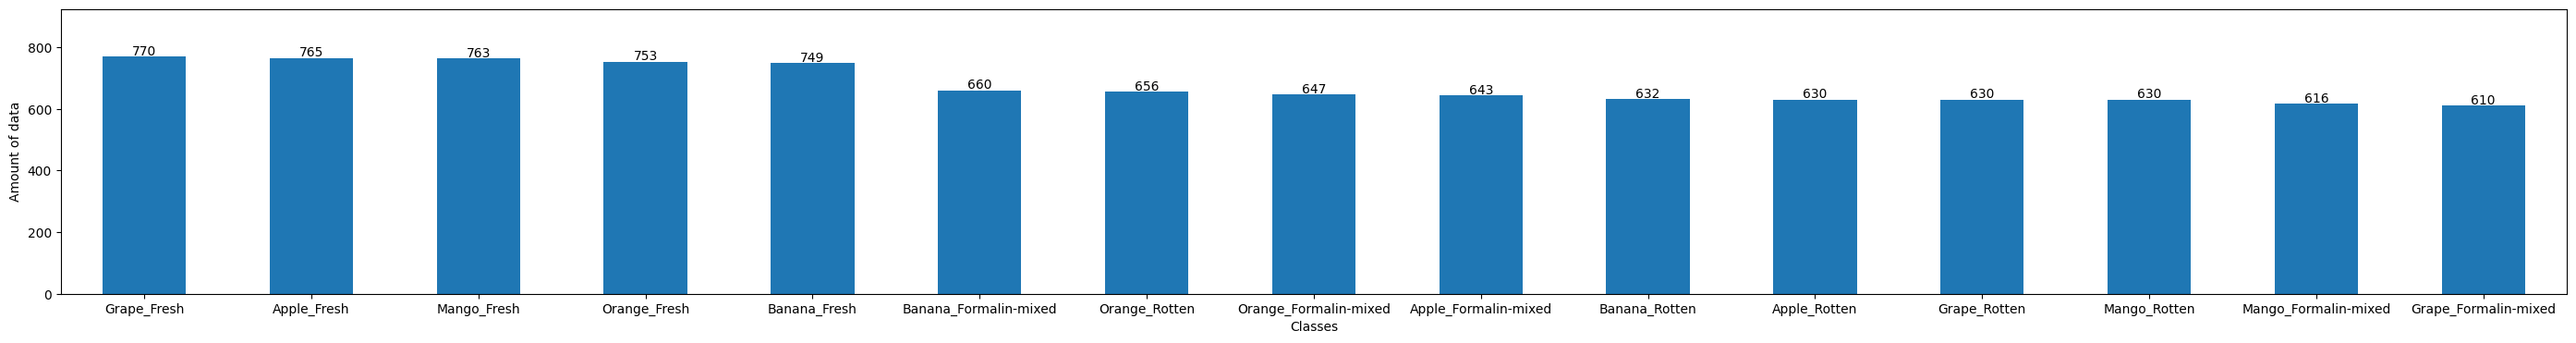

In [6]:
class_counts_train = df['label'].value_counts()

for class_name, count in class_counts_train.items():
    print(f"Class: {class_name}, Count: {count}")

plt.figure(figsize=(35, 4))
ax = class_counts_train.plot(kind='bar')
plt.xlabel('Classes')
plt.ylabel('Amount of data')
plt.xticks(rotation=360)
for i, count in enumerate(class_counts_train):
    ax.text(i, count + 5, str(count), ha='center')
plt.ylim(0, max(class_counts_train) * 1.2)
plt.show()

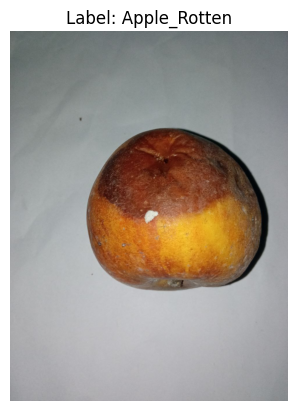

In [7]:
random_index = random.randint(1, len(df) - 1)
random_row = df.iloc[random_index]

file_path = random_row['file_path']
label = random_row['label']

image = Image.open(file_path)
plt.imshow(image)
plt.title(f"Label: {label}")
plt.axis('off')
plt.show()

### Train-Test-Validation Split (Ratio 70:15:15)

In [8]:
train_dataframe, temp_dataframe = train_test_split(df, test_size=0.30, 
                                     stratify=df['label'], random_state=42)
valid_dataframe, test_df = train_test_split(temp_dataframe, test_size=0.50, 
                                            stratify=temp_dataframe['label'], random_state=42)

In [9]:
print("Training Data: ", len(train_dataframe))
print("Validation Data: ", len(valid_dataframe))
print("Test Data: ", len(test_df))
print("-------------------------------------------")
print("Total amounts of data in the dataset: ", len(df))

Training Data:  7107
Validation Data:  1523
Test Data:  1524
-------------------------------------------
Total amounts of data in the dataset:  10154


In [11]:
class_counts_train = train_dataframe['label'].value_counts()
class_counts_valid = valid_dataframe['label'].value_counts()
class_counts_test = test_df['label'].value_counts()

train_table_data = [[class_name, count] for class_name, count in class_counts_train.items()]
valid_table_data = [[class_name, count] for class_name, count in class_counts_valid.items()]
test_table_data = [[class_name, count] for class_name, count in class_counts_test.items()]

print("Train Dataset")
print(tabulate(train_table_data, headers=["Class", "Count"]))
print("\nValidation Dataset")
print(tabulate(valid_table_data, headers=["Class", "Count"]))
print("\nTest Dataset")
print(tabulate(test_table_data, headers=["Class", "Count"]))

Train Dataset
Class                    Count
---------------------  -------
Grape_Fresh                539
Apple_Fresh                536
Mango_Fresh                534
Orange_Fresh               527
Banana_Fresh               524
Banana_Formalin-mixed      462
Orange_Rotten              459
Orange_Formalin-mixed      453
Apple_Formalin-mixed       450
Banana_Rotten              442
Apple_Rotten               441
Grape_Rotten               441
Mango_Rotten               441
Mango_Formalin-mixed       431
Grape_Formalin-mixed       427

Validation Dataset
Class                    Count
---------------------  -------
Grape_Fresh                115
Apple_Fresh                114
Mango_Fresh                114
Orange_Fresh               113
Banana_Fresh               112
Banana_Formalin-mixed       99
Orange_Rotten               98
Orange_Formalin-mixed       97
Apple_Formalin-mixed        96
Mango_Rotten                95
Banana_Rotten               95
Grape_Rotten                95
Apple

### Device Variable

In [12]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


### Checkpoint

In [14]:
save_path_checkpoints = "/kaggle/working/"
os.makedirs(save_path_checkpoints, exist_ok=True)

# Data Transfer

In [15]:
# Build the label map from your combined labels (e.g. Apple_Fresh, etc.)
unique_labels = sorted(df['label'].unique())
label_map = {label: idx for idx, label in enumerate(unique_labels)}
total_class = len(label_map)  # <- pass this to model.fc

### Dataset Class, Dataloader and Transform

In [17]:
class ImageDataset(Dataset):
    def __init__(self, dataframe, normalize, label_map, is_lb=True):
        self.dataframe = dataframe
        self.normalize = normalize
        self.label_map = label_map  
        self.is_lb = is_lb

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, index):
        img_path = self.dataframe.iloc[index]['file_path']
        image = Image.open(img_path).convert('RGB')  

        if self.is_lb:
            label_str = self.dataframe.iloc[index]['label']
            label = self.label_map[label_str]  
            return self.normalize(image), label
        else:
            return self.normalize(image), self.normalize(image)

In [18]:
train_batch = 32
val_batch = 8

def data_transform(label_map):
    normalize = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor()
    ])

    train_dataset = ImageDataset(
        dataframe=train_dataframe,
        normalize=normalize,
        label_map=label_map,
        is_lb=True
    )

    valid_dataset = ImageDataset(
        dataframe=valid_dataframe,
        normalize=normalize,
        label_map=label_map,
        is_lb=True
    )

    test_dataset = ImageDataset(
        dataframe=test_df,
        normalize=normalize,
        label_map=label_map,
        is_lb=True
    )

    dataloader_train = DataLoader(train_dataset, batch_size=train_batch, shuffle=True, num_workers=2)
    dataloader_valid = DataLoader(valid_dataset, batch_size=val_batch, shuffle=False, num_workers=2)
    dataloader_test = DataLoader(test_dataset, batch_size=val_batch, shuffle=False, num_workers=2)

    return dataloader_train, dataloader_valid, dataloader_test

In [19]:
dataloader_train_dataset, dataloader_valid_dataset, dataloader_test_dataset = data_transform(label_map)


### C.N.N

In [20]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from tqdm import tqdm
import pandas as pd
import os
import time

train_batch = 32
val_batch = 8
learning_rate = 0.0001
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
total_class = len(label_map)
save_path_checkpoints = "checkpoints"
os.makedirs(save_path_checkpoints, exist_ok=True)

# ------------------------------
# SE Block
# ------------------------------
class SEBlock(nn.Module):
    def __init__(self, channels, reduction=16):
        super(SEBlock, self).__init__()
        self.fc1 = nn.Linear(channels, channels // reduction)
        self.fc2 = nn.Linear(channels // reduction, channels)

    def forward(self, x):
        batch_size, channels, H, W = x.size()
        # Squeeze: Global Average Pooling
        y = x.view(batch_size, channels, -1).mean(dim=2)
        # Excitation
        y = F.relu(self.fc1(y))
        y = torch.sigmoid(self.fc2(y))
        y = y.view(batch_size, channels, 1, 1)
        return x * y  # Scale feature maps

# ------------------------------
# CNN + SE Model
# ------------------------------
class myyCNN_SE(nn.Module):
    def __init__(self, num_classes=2):
        super(myyCNN_SE, self).__init__()
        
        # Conv blocks
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.se1 = SEBlock(32)

        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.se2 = SEBlock(64)

        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.se3 = SEBlock(128)
        
        # Pooling
        self.pool = nn.MaxPool2d(2, 2)
        
        # Fully connected
        self.fc1 = nn.Linear(128 * 28 * 28, 512)  # compatible with 224x224
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(512, num_classes)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.se1(x)
        x = self.pool(x)

        x = F.relu(self.bn2(self.conv2(x)))
        x = self.se2(x)
        x = self.pool(x)

        x = F.relu(self.bn3(self.conv3(x)))
        x = self.se3(x)
        x = self.pool(x)

        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        out = self.fc2(x)
        return out

    def extract_features(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.se1(x)
        x = self.pool(x)

        x = F.relu(self.bn2(self.conv2(x)))
        x = self.se2(x)
        x = self.pool(x)

        x = F.relu(self.bn3(self.conv3(x)))
        x = self.se3(x)
        x = self.pool(x)

        x = x.view(x.size(0), -1)
        features = F.relu(self.fc1(x))
        return features

# ------------------------------
# Initialize
# ------------------------------
model = myyCNN_SE(num_classes=total_class).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# ------------------------------
# Training function
# ------------------------------
def train_model(model, criterion, optimizer, dataloader_train, dataloader_valid, num_epochs=20):
    train_loss_history, train_acc_history = [], []
    val_loss_history, val_acc_history = [], []
    best_val_acc = 0.0

    for epoch in range(num_epochs):
        # ---- Training ----
        model.train()
        running_loss, correct_train, total_train = 0, 0, 0
        for inputs, labels in tqdm(dataloader_train, desc=f"Epoch {epoch+1}/{num_epochs} [Train]"):
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            _, predicted = torch.max(outputs, 1)
            running_loss += loss.item() * inputs.size(0)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()
        epoch_train_loss = running_loss / total_train
        epoch_train_acc = correct_train / total_train
        train_loss_history.append(epoch_train_loss)
        train_acc_history.append(epoch_train_acc)
        print(f"Training Loss: {epoch_train_loss:.4f} Acc: {epoch_train_acc:.4f}")

        # ---- Validation ----
        model.eval()
        running_loss, correct_val, total_val = 0, 0, 0
        with torch.no_grad():
            for inputs, labels in dataloader_valid:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                _, predicted = torch.max(outputs, 1)
                running_loss += loss.item() * inputs.size(0)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()
        epoch_val_loss = running_loss / total_val
        epoch_val_acc = correct_val / total_val
        val_loss_history.append(epoch_val_loss)
        val_acc_history.append(epoch_val_acc)
        print(f"Validation Loss: {epoch_val_loss:.4f} Acc: {epoch_val_acc:.4f}")

        # ---- Save best model ----
        if epoch_val_acc > best_val_acc:
            best_val_acc = epoch_val_acc
            checkpoint = {
                "epoch": epoch + 1,
                "model_weight": model.state_dict(),
                "optimizer_state": optimizer.state_dict()
            }
            torch.save(checkpoint, f"{save_path_checkpoints}/best_model_se.pt")
            print(f"Best model saved at epoch {epoch+1} with validation accuracy: {best_val_acc:.4f}")

    return train_loss_history, train_acc_history, val_loss_history, val_acc_history

# ------------------------------
# Run training
# ------------------------------
start_time = time.time()
train_loss_history, train_acc_history, val_loss_history, val_acc_history = train_model(
    model, criterion, optimizer, dataloader_train_dataset, dataloader_valid_dataset, num_epochs=20
)
end_time = time.time()
training_time = end_time - start_time
print(f"Total Training Time: {training_time:.2f} sec ({training_time/60:.2f} min)")

# Save training history
history = pd.DataFrame({
    'Epoch': list(range(1, len(train_loss_history)+1)),
    'Train Loss': train_loss_history,
    'Train Accuracy': train_acc_history,
    'Validation Loss': val_loss_history,
    'Validation Accuracy': val_acc_history
})
history.to_excel('/kaggle/working/training_history_se.xlsx', index=False)


Epoch 1/20 [Train]: 100%|██████████| 223/223 [01:52<00:00,  1.99it/s]

Training Loss: 1.0736 Acc: 0.6198


Validation Loss: 0.5261 Acc: 0.8004
Best model saved at epoch 1 with validation accuracy: 0.8004


Epoch 2/20 [Train]: 100%|██████████| 223/223 [01:26<00:00,  2.57it/s]

Training Loss: 0.5965 Acc: 0.7760


Validation Loss: 0.4419 Acc: 0.8214
Best model saved at epoch 2 with validation accuracy: 0.8214


Epoch 3/20 [Train]: 100%|██████████| 223/223 [01:25<00:00,  2.62it/s]

Training Loss: 0.4764 Acc: 0.8162


Validation Loss: 0.3827 Acc: 0.8582
Best model saved at epoch 3 with validation accuracy: 0.8582


Epoch 4/20 [Train]: 100%|██████████| 223/223 [01:25<00:00,  2.61it/s]

Training Loss: 0.4367 Acc: 0.8359


Validation Loss: 0.3176 Acc: 0.8726
Best model saved at epoch 4 with validation accuracy: 0.8726


Epoch 5/20 [Train]: 100%|██████████| 223/223 [01:26<00:00,  2.58it/s]

Training Loss: 0.3481 Acc: 0.8691


Validation Loss: 0.3059 Acc: 0.8910
Best model saved at epoch 5 with validation accuracy: 0.8910


Epoch 6/20 [Train]: 100%|██████████| 223/223 [01:26<00:00,  2.57it/s]

Training Loss: 0.3096 Acc: 0.8824


Validation Loss: 0.2655 Acc: 0.8930
Best model saved at epoch 6 with validation accuracy: 0.8930


Epoch 7/20 [Train]: 100%|██████████| 223/223 [01:24<00:00,  2.63it/s]

Training Loss: 0.3018 Acc: 0.8845


Validation Loss: 0.2526 Acc: 0.9048
Best model saved at epoch 7 with validation accuracy: 0.9048


Epoch 8/20 [Train]: 100%|██████████| 223/223 [01:24<00:00,  2.63it/s]

Training Loss: 0.2584 Acc: 0.9021


Validation Loss: 0.2646 Acc: 0.9002


Epoch 9/20 [Train]: 100%|██████████| 223/223 [01:24<00:00,  2.65it/s]

Training Loss: 0.2465 Acc: 0.9094


Validation Loss: 0.2495 Acc: 0.8995


Epoch 10/20 [Train]: 100%|██████████| 223/223 [01:24<00:00,  2.63it/s]

Training Loss: 0.1905 Acc: 0.9285


Validation Loss: 0.2712 Acc: 0.9068
Best model saved at epoch 10 with validation accuracy: 0.9068


Epoch 11/20 [Train]: 100%|██████████| 223/223 [01:25<00:00,  2.62it/s]

Training Loss: 0.2013 Acc: 0.9239


Validation Loss: 0.2421 Acc: 0.9133
Best model saved at epoch 11 with validation accuracy: 0.9133


Epoch 12/20 [Train]: 100%|██████████| 223/223 [01:24<00:00,  2.65it/s]

Training Loss: 0.1855 Acc: 0.9323


Validation Loss: 0.2397 Acc: 0.9114


Epoch 13/20 [Train]: 100%|██████████| 223/223 [01:24<00:00,  2.64it/s]

Training Loss: 0.1706 Acc: 0.9336


Validation Loss: 0.2495 Acc: 0.9133


Epoch 14/20 [Train]: 100%|██████████| 223/223 [01:24<00:00,  2.63it/s]

Training Loss: 0.1582 Acc: 0.9425


Validation Loss: 0.2199 Acc: 0.9179
Best model saved at epoch 14 with validation accuracy: 0.9179


Epoch 15/20 [Train]: 100%|██████████| 223/223 [01:25<00:00,  2.62it/s]

Training Loss: 0.1436 Acc: 0.9457


Validation Loss: 0.2296 Acc: 0.9179


Epoch 16/20 [Train]: 100%|██████████| 223/223 [01:25<00:00,  2.60it/s]

Training Loss: 0.1401 Acc: 0.9479


Validation Loss: 0.1990 Acc: 0.9304
Best model saved at epoch 16 with validation accuracy: 0.9304


Epoch 17/20 [Train]: 100%|██████████| 223/223 [01:24<00:00,  2.63it/s]

Training Loss: 0.1285 Acc: 0.9515


Validation Loss: 0.2611 Acc: 0.9140


Epoch 18/20 [Train]: 100%|██████████| 223/223 [01:23<00:00,  2.67it/s]

Training Loss: 0.1339 Acc: 0.9500


Validation Loss: 0.2298 Acc: 0.9304


Epoch 19/20 [Train]: 100%|██████████| 223/223 [01:24<00:00,  2.64it/s]

Training Loss: 0.1201 Acc: 0.9544


Validation Loss: 0.2530 Acc: 0.9120


Epoch 20/20 [Train]: 100%|██████████| 223/223 [01:24<00:00,  2.62it/s]

Training Loss: 0.1011 Acc: 0.9629


Validation Loss: 0.1890 Acc: 0.9343
Best model saved at epoch 20 with validation accuracy: 0.9343
Total Training Time: 2109.80 sec (35.16 min)


### Training

In [21]:
start_time = time.time()
def train_model(model, criterion, optimizer, dataloader_train_dataset, dataloader_valid_dataset, num_epochs=20,  save_path_checkpoints="checkpoints"):
    train_loss_history = []
    train_acc_history = []
    val_loss_history = []
    val_acc_history = []

    best_val_acc = 0.0
    consecutive_no_improvement = 0
    num_epochs_loss_greater = 0

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0

        progress_bar = tqdm(enumerate(dataloader_train_dataset), total=len(dataloader_train_dataset))
        for i, (inputs, labels) in progress_bar:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            _, predicted = torch.max(outputs, 1)
            running_loss += loss.item() * inputs.size(0)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

            progress_bar.set_description(f"Epoch {epoch+1}/{num_epochs}")
            progress_bar.set_postfix(loss=running_loss / total_train, acc=correct_train / total_train)
        epoch_train_loss = running_loss / total_train
        epoch_train_acc = correct_train / total_train
        train_loss_history.append(epoch_train_loss)
        train_acc_history.append(epoch_train_acc)

        print('Training Loss: {:.3f} Acc: {:.3f}'.format(epoch_train_loss, epoch_train_acc))

        model.eval()
        running_loss = 0.0
        correct_val = 0
        total_val = 0

        with torch.no_grad():
            for inputs, labels in dataloader_valid_dataset:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                _, predicted = torch.max(outputs, 1)
                running_loss += loss.item() * inputs.size(0)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()

        epoch_val_loss = running_loss / total_val
        epoch_val_acc = correct_val / total_val
        val_loss_history.append(epoch_val_loss)
        val_acc_history.append(epoch_val_acc)

        print('Validation Loss: {:.3f} Acc: {:.3f}'.format(epoch_val_loss, epoch_val_acc))

        if epoch_val_acc > best_val_acc:
            best_val_acc = epoch_val_acc
            best_epoch = epoch + 1
            filepath = f"{save_path_checkpoints}/model.pt"
            checkpoint = {
                "epoch": epoch + 1,
                "model_weight": model.state_dict(),
                "optimizer_state": optimizer.state_dict()
            }
            torch.save(checkpoint, filepath)
            print(f"Best model saved at epoch {best_epoch} with validation accuracy: {best_val_acc:.3f}")
            consecutive_no_improvement = 0
        else:
            consecutive_no_improvement += 1

        if epoch_val_loss > epoch_train_loss:
            num_epochs_loss_greater += 1
        else:
            num_epochs_loss_greater = 0


    return train_loss_history, train_acc_history, val_loss_history, val_acc_history


train_loss_history, train_acc_history, val_loss_history, val_acc_history = train_model(model, criterion, optimizer, dataloader_train_dataset, dataloader_valid_dataset, save_path_checkpoints=save_path_checkpoints)

end_time = time.time()
training_time = end_time - start_time
print(f"Training Time: {training_time:.2f} seconds ---> {training_time/60:.2f} minutes")

data = {
    'Epoch': list(range(1, len(train_loss_history) + 1)),
    'Train Loss': train_loss_history,
    'Train Accuracy': train_acc_history,
    'Validation Loss': val_loss_history,
    'Validation Accuracy': val_acc_history
}

history = pd.DataFrame(data)
history.to_excel('/kaggle/working/training_data.xlsx', index=False)

Epoch 1/20: 100%|██████████| 223/223 [01:24<00:00,  2.65it/s, acc=0.963, loss=0.0991]

Training Loss: 0.099 Acc: 0.963


Validation Loss: 0.248 Acc: 0.924
Best model saved at epoch 1 with validation accuracy: 0.924


Epoch 2/20: 100%|██████████| 223/223 [01:25<00:00,  2.61it/s, acc=0.962, loss=0.102] 

Training Loss: 0.102 Acc: 0.962


Validation Loss: 0.204 Acc: 0.928
Best model saved at epoch 2 with validation accuracy: 0.928


Epoch 3/20: 100%|██████████| 223/223 [01:26<00:00,  2.58it/s, acc=0.963, loss=0.0929]

Training Loss: 0.093 Acc: 0.963


Validation Loss: 0.201 Acc: 0.936
Best model saved at epoch 3 with validation accuracy: 0.936


Epoch 4/20: 100%|██████████| 223/223 [01:25<00:00,  2.62it/s, acc=0.969, loss=0.085] 

Training Loss: 0.085 Acc: 0.969


Validation Loss: 0.193 Acc: 0.941
Best model saved at epoch 4 with validation accuracy: 0.941


Epoch 5/20: 100%|██████████| 223/223 [01:23<00:00,  2.67it/s, acc=0.969, loss=0.0921]

Training Loss: 0.092 Acc: 0.969


Validation Loss: 0.194 Acc: 0.937


Epoch 6/20: 100%|██████████| 223/223 [01:24<00:00,  2.62it/s, acc=0.962, loss=0.11] 

Training Loss: 0.110 Acc: 0.962


Validation Loss: 0.260 Acc: 0.928


Epoch 7/20: 100%|██████████| 223/223 [01:24<00:00,  2.64it/s, acc=0.963, loss=0.0947]

Training Loss: 0.095 Acc: 0.963


Validation Loss: 0.210 Acc: 0.930


Epoch 8/20: 100%|██████████| 223/223 [01:23<00:00,  2.69it/s, acc=0.97, loss=0.0755] 

Training Loss: 0.075 Acc: 0.970


Validation Loss: 0.280 Acc: 0.921


Epoch 9/20: 100%|██████████| 223/223 [01:23<00:00,  2.66it/s, acc=0.967, loss=0.0886]

Training Loss: 0.089 Acc: 0.967


Validation Loss: 0.219 Acc: 0.930


Epoch 10/20: 100%|██████████| 223/223 [01:23<00:00,  2.66it/s, acc=0.966, loss=0.0904]

Training Loss: 0.090 Acc: 0.966


Validation Loss: 0.239 Acc: 0.925


Epoch 11/20: 100%|██████████| 223/223 [01:23<00:00,  2.68it/s, acc=0.973, loss=0.0745]

Training Loss: 0.075 Acc: 0.973


Validation Loss: 0.241 Acc: 0.925


Epoch 12/20: 100%|██████████| 223/223 [01:24<00:00,  2.65it/s, acc=0.979, loss=0.0631]

Training Loss: 0.063 Acc: 0.979


Validation Loss: 0.217 Acc: 0.927


Epoch 13/20: 100%|██████████| 223/223 [01:25<00:00,  2.61it/s, acc=0.976, loss=0.0645]

Training Loss: 0.065 Acc: 0.976


Validation Loss: 0.201 Acc: 0.937


Epoch 14/20: 100%|██████████| 223/223 [01:24<00:00,  2.64it/s, acc=0.979, loss=0.0614]

Training Loss: 0.061 Acc: 0.979


Validation Loss: 0.215 Acc: 0.928


Epoch 15/20: 100%|██████████| 223/223 [01:23<00:00,  2.67it/s, acc=0.977, loss=0.0624]

Training Loss: 0.062 Acc: 0.977


Validation Loss: 0.263 Acc: 0.926


Epoch 16/20: 100%|██████████| 223/223 [01:24<00:00,  2.65it/s, acc=0.977, loss=0.0647]

Training Loss: 0.065 Acc: 0.977


Validation Loss: 0.190 Acc: 0.947
Best model saved at epoch 16 with validation accuracy: 0.947


Epoch 17/20: 100%|██████████| 223/223 [01:24<00:00,  2.64it/s, acc=0.979, loss=0.0587]

Training Loss: 0.059 Acc: 0.979


Validation Loss: 0.227 Acc: 0.946


Epoch 18/20: 100%|██████████| 223/223 [01:24<00:00,  2.63it/s, acc=0.978, loss=0.0593]

Training Loss: 0.059 Acc: 0.978


Validation Loss: 0.192 Acc: 0.945


Epoch 19/20: 100%|██████████| 223/223 [01:24<00:00,  2.63it/s, acc=0.983, loss=0.0504]

Training Loss: 0.050 Acc: 0.983


Validation Loss: 0.211 Acc: 0.941


Epoch 20/20: 100%|██████████| 223/223 [01:22<00:00,  2.69it/s, acc=0.983, loss=0.0483]

Training Loss: 0.048 Acc: 0.983


Validation Loss: 0.304 Acc: 0.922
Training Time: 2045.68 seconds ---> 34.09 minutes


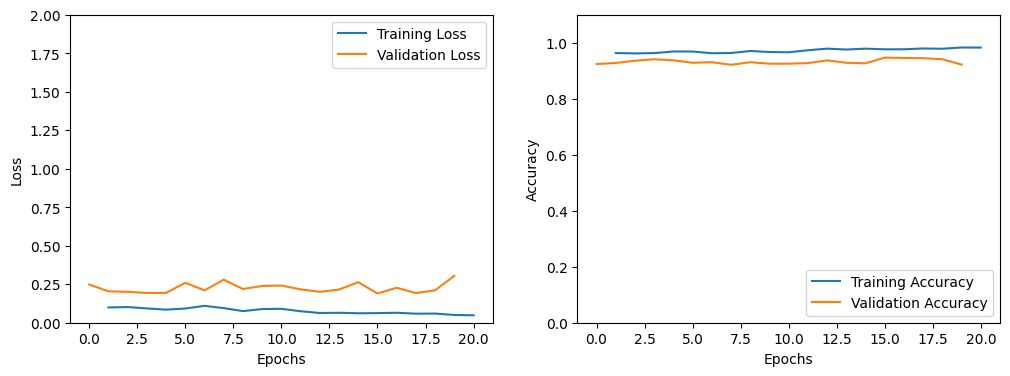

In [22]:
history = pd.read_excel('/kaggle/working/training_data.xlsx')

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history['Epoch'], history['Train Loss'], label='Train Loss')
plt.plot(history['Validation Loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Training Loss', 'Validation Loss'], loc='upper right')
plt.ylim(0,2)

plt.subplot(1, 2, 2)
plt.plot(history['Epoch'], history['Train Accuracy'], label='Train Accuracy')
plt.plot(history['Validation Accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Training Accuracy', 'Validation Accuracy'], loc='lower right')
plt.ylim(0,1.1)

plt.show()

### Execution Model ML

In [23]:
# ML Classifiers on CNN Features
import numpy as np
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score
import time
from tqdm import tqdm

model.eval()

# Helper: extract features from dataset
def extract_features(dataloader, model):
    features_list = []
    labels_list = []
    with torch.no_grad():
        for imgs, labels in tqdm(dataloader):
            imgs = imgs.to(device)
            features = model.extract_features(imgs)  # use your extract_features method
            features_list.append(features.cpu().numpy())
            labels_list.append(labels.numpy())
    X = np.concatenate(features_list, axis=0)
    y = np.concatenate(labels_list, axis=0)
    return X, y

# Extract features
X_train, y_train = extract_features(dataloader_train_dataset, model)
X_valid, y_valid = extract_features(dataloader_valid_dataset, model)
X_test, y_test = extract_features(dataloader_test_dataset, model)


# Define classifiers
classifiers = {
    "SVM": SVC(kernel='rbf', probability=True),
    "KNN": KNeighborsClassifier(n_neighbors=5),
    "Random Forest": RandomForestClassifier(n_estimators=200),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
}



# Train and evaluate
results = {}
for name, clf in classifiers.items():
    start_time = time.time()
    clf.fit(X_train, y_train)
    train_time = time.time() - start_time
    
    start_time = time.time()
    y_pred = clf.predict(X_test)
    test_time = time.time() - start_time
    
    acc = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, digits=4)
    cm = confusion_matrix(y_test, y_pred)
    
    results[name] = {
        "accuracy": acc,
        "classification_report": report,
        "confusion_matrix": cm,
        "train_time": train_time,
        "test_time": test_time
    }
    
    print(f"\n{name} Results:")
    print(f"Accuracy: {acc:.4f}")
    print(f"Training Time: {train_time:.2f}s, Testing Time: {test_time:.2f}s")
    print("Classification Report:\n", report)
    print("Confusion Matrix:\n", cm)


100%|██████████| 191/191 [00:24<00:00,  7.89it/s]



SVM Results:
Accuracy: 0.9409
Training Time: 7.83s, Testing Time: 1.13s
Classification Report:
               precision    recall  f1-score   support

           0     0.9029    0.9588    0.9300        97
           1     0.8992    0.9304    0.9145       115
           2     0.9881    0.8830    0.9326        94
           3     0.8596    0.9899    0.9202        99
           4     0.9802    0.8761    0.9252       113
           5     1.0000    0.9474    0.9730        95
           6     0.9348    0.9451    0.9399        91
           7     0.9160    0.9397    0.9277       116
           8     0.9333    0.8936    0.9130        94
           9     0.9293    1.0000    0.9634        92
          10     1.0000    0.9739    0.9868       115
          11     0.9890    0.9574    0.9730        94
          12     0.9175    0.9175    0.9175        97
          13     0.9224    0.9469    0.9345       113
          14     0.9794    0.9596    0.9694        99

    accuracy                         

### Evaluation ML

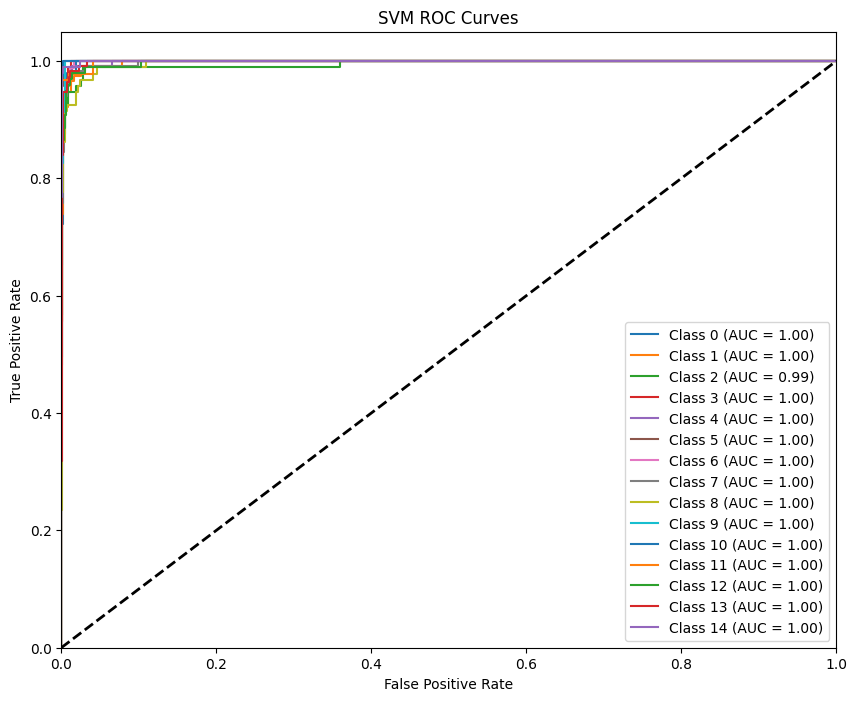


SVM Final Accuracy: 0.9409


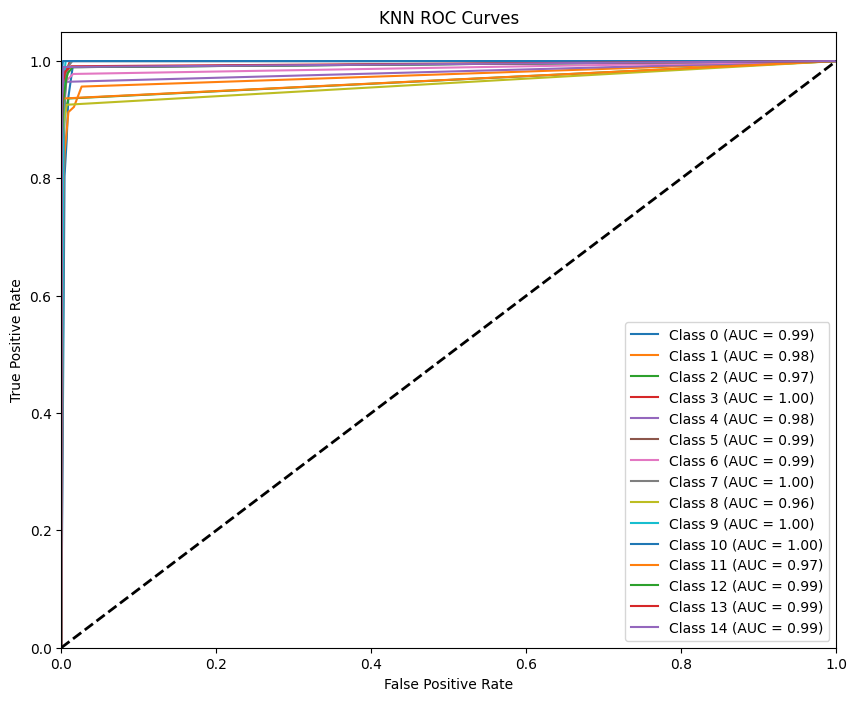


KNN Final Accuracy: 0.9423


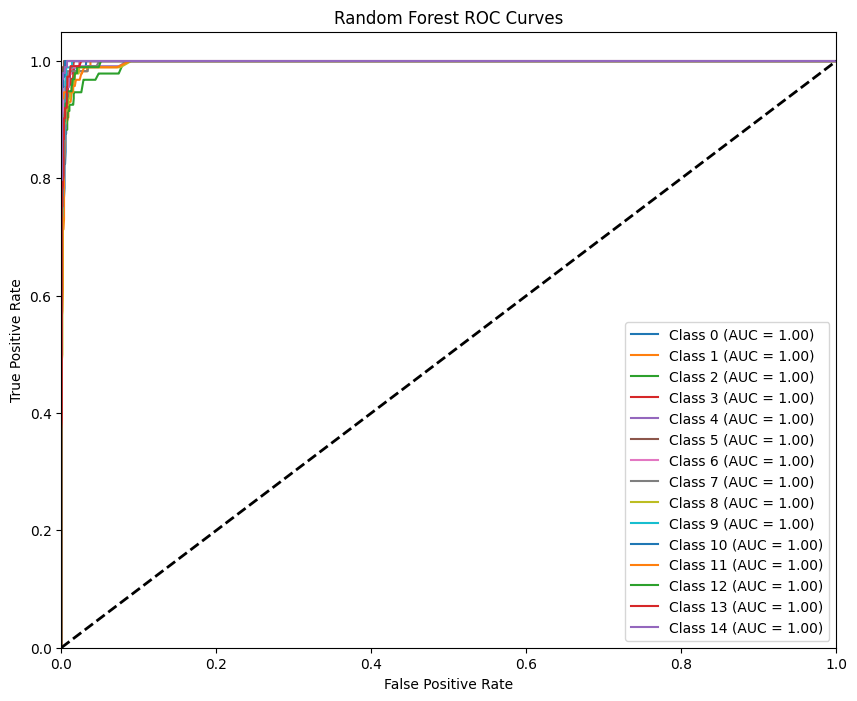


Random Forest Final Accuracy: 0.9364


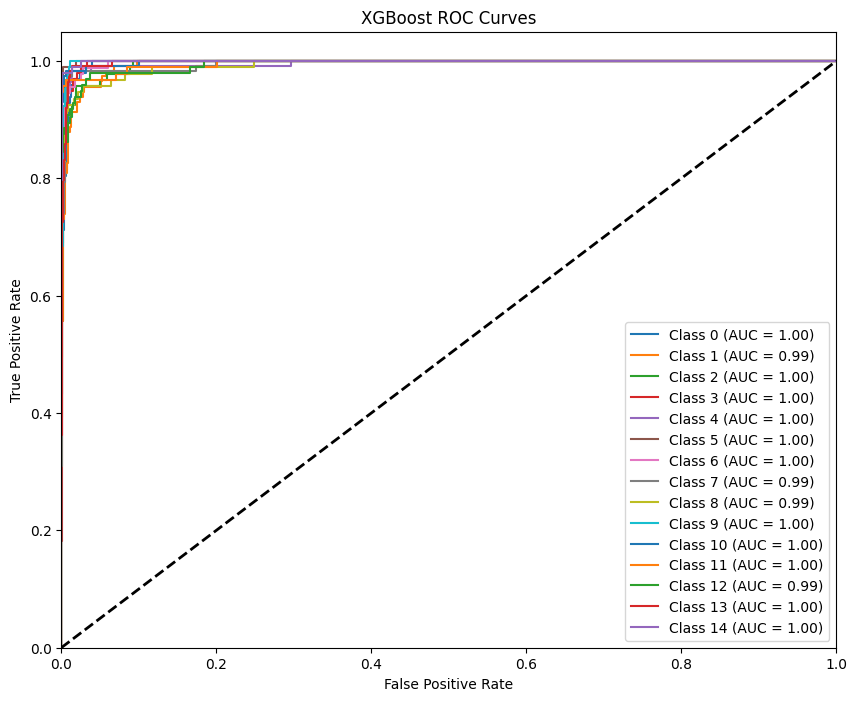


XGBoost Final Accuracy: 0.9219


In [24]:
import matplotlib.pyplot as plt
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc

#ROC Curves and AUC class for each classifier
n_classes = total_class 
y_test_binarized = label_binarize(y_test, classes=np.arange(n_classes))

for name, clf in classifiers.items():
    y_score = None
    if hasattr(clf, "predict_proba"):
        y_score = clf.predict_proba(X_test)
    elif hasattr(clf, "decision_function"):
        y_score = clf.decision_function(X_test)
    
    if y_score is None:
        print(f"{name} does not support probability scores for ROC/AUC.")
        continue

    #Compute ROC curve and AUC
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    #ROC curves
    plt.figure(figsize=(10, 8))
    for i in range(n_classes):
        plt.plot(fpr[i], tpr[i], label=f"Class {i} (AUC = {roc_auc[i]:.2f})")
    plt.plot([0, 1], [0, 1], "k--", lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"{name} ROC Curves")
    plt.legend(loc="lower right")
    plt.show()
    
    #print metrics
    y_pred = clf.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    print(f"\n{name} Final Accuracy: {acc:.4f}")


### Evaluation

In [26]:
def evaluate_model(model, criterion, dataloader):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            _, predicted = torch.max(outputs, 1)
            running_loss += loss.item() * inputs.size(0)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    loss = running_loss / total
    accuracy = correct / total

    return loss, accuracy

In [27]:
best_checkpoint_path = f"{save_path_checkpoints}/model.pt"
checkpoint = torch.load(best_checkpoint_path)
best_epoch = checkpoint["epoch"]
model.load_state_dict(checkpoint["model_weight"])
optimizer.load_state_dict(checkpoint["optimizer_state"])

best_val_loss, best_val_accuracy = evaluate_model(model, criterion, dataloader_valid_dataset)
print(f"Best model (from epoch {best_epoch}) - Validation Loss: {best_val_loss:.3f}, Validation Accuracy: {best_val_accuracy:.3f}")

Best model (from epoch 16) - Validation Loss: 0.190, Validation Accuracy: 0.947


In [28]:
start_time = time.time()

test_loss, test_accuracy = evaluate_model(model, criterion, dataloader_test_dataset)
print(f"Test Accuracy: {test_accuracy:.3f}")

end_time = time.time()
test_time = end_time - start_time
print(f"Test Time: {test_time:.2f} seconds ---> {test_time/60:.2f} minutes")

Test Accuracy: 0.935
Test Time: 17.51 seconds ---> 0.29 minutes


In [30]:
def class_accuracy(model, dataloader, num_classes):
    class_correct = [0.0] * num_classes
    class_total = [0.0] * num_classes

    model.eval()
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            correct = (predicted == labels)
            for i in range(len(labels)):
                label = labels[i]
                class_correct[label] += correct[i].item()
                class_total[label] += 1

    class_accuracy = [class_correct[i] / class_total[i] if class_total[i] > 0 else 0 for i in range(num_classes)]

    return class_accuracy

y_true = []
y_pred = []

model.eval()
with torch.no_grad():
    for inputs, labels in dataloader_test_dataset:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

y_true = np.array(y_true)
y_pred = np.array(y_pred)

class_names = [str(i) for i in range(total_class)]

print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

class_acc = class_accuracy(model, dataloader_test_dataset, total_class)
for i in range(total_class):
    print(f"Class {i} Accuracy: {class_acc[i]:.3f}")

Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.88      0.89        97
           1       0.82      0.92      0.87       115
           2       0.98      0.87      0.92        94
           3       0.91      0.97      0.94        99
           4       0.95      0.89      0.92       113
           5       0.98      0.98      0.98        95
           6       0.96      0.95      0.95        91
           7       0.93      0.93      0.93       116
           8       0.93      0.94      0.93        94
           9       0.94      0.98      0.96        92
          10       0.99      0.97      0.98       115
          11       0.98      0.96      0.97        94
          12       0.94      0.90      0.92        97
          13       0.91      0.95      0.93       113
          14       0.96      0.96      0.96        99

    accuracy                           0.94      1524
   macro avg       0.94      0.94      0.94      1524
wei

### Grad CAM

In [32]:
import torch
import torch.nn.functional as F

class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None

        # Register hooks
        target_layer.register_forward_hook(self.save_activation)
        target_layer.register_full_backward_hook(self.save_gradient)

    def save_activation(self, module, input, output):
        self.activations = output.detach()

    def save_gradient(self, module, grad_input, grad_output):
        self.gradients = grad_output[0].detach()

    def __call__(self, x, class_idx=None):
        """
        x: input tensor, shape (B, C, H, W)
        class_idx: list of integers (B length) or None for predicted classes
        """
        x = x.to(next(self.model.parameters()).device)  # ensure same device as model
        self.model.zero_grad()
        output = self.model(x)

        # If class_idx is None, use predicted classes
        if class_idx is None:
            class_idx = output.argmax(dim=1)

        # Make sure class_idx is a tensor on same device
        if not isinstance(class_idx, torch.Tensor):
            class_idx = torch.tensor(class_idx, device=x.device)

        # Compute gradients
        loss = output.gather(1, class_idx.view(-1,1)).squeeze()
        loss.backward(torch.ones_like(loss), retain_graph=True)

        # Compute weights
        weights = self.gradients.mean(dim=(2,3), keepdim=True)
        grad_cam_map = (weights * self.activations).sum(dim=1, keepdim=True)
        grad_cam_map = F.relu(grad_cam_map)

        # Resize to input size
        grad_cam_map = F.interpolate(
            grad_cam_map, size=(x.size(2), x.size(3)),
            mode='bilinear', align_corners=False
        )

        # Normalize per sample
        maps = []
        for i in range(grad_cam_map.size(0)):
            m = grad_cam_map[i,0].cpu().numpy()
            m = (m - m.min()) / (m.max() - m.min() + 1e-8)
            maps.append(m)
        return maps if len(maps) > 1 else maps[0]


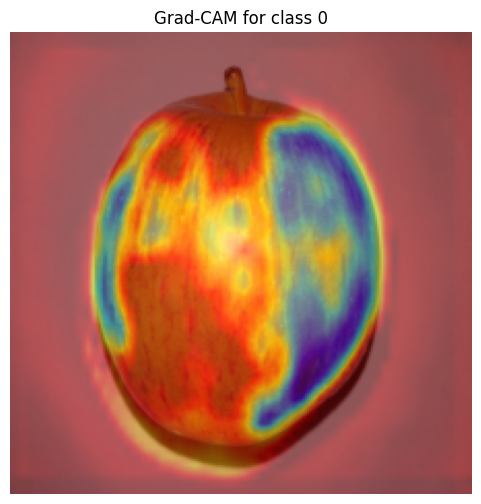

In [33]:
import matplotlib.pyplot as plt
import cv2
import numpy as np

# Pick a single image from test DataLoader
image_batch, label_batch = next(iter(dataloader_test_dataset))
image_tensor = image_batch[0].unsqueeze(0).to(device)  # add batch dim
true_label = label_batch[0].item()

# Initialize Grad-CAM for last conv layer
grad_cam = GradCAM(model, model.conv3)

# Generate Grad-CAM heatmap
cam_map = grad_cam(image_tensor, class_idx=[true_label])

# Convert tensor image to numpy (HWC) for overlay
img_np = image_tensor.squeeze().cpu().permute(1, 2, 0).numpy()
img_np = (img_np - img_np.min()) / (img_np.max() - img_np.min())  # normalize 0-1

# Resize CAM map to match image size
cam_map_resized = cv2.resize(cam_map, (img_np.shape[1], img_np.shape[0]))

# Overlay heatmap
heatmap = cv2.applyColorMap(np.uint8(255 * cam_map_resized), cv2.COLORMAP_JET)
heatmap = np.float32(heatmap) / 255
overlayed_img = heatmap + np.float32(img_np)
overlayed_img = overlayed_img / overlayed_img.max()

plt.figure(figsize=(6,6))
plt.imshow(overlayed_img)
plt.axis('off')
plt.title(f"Grad-CAM for class {true_label}")
plt.show()


### Confusion Metrix

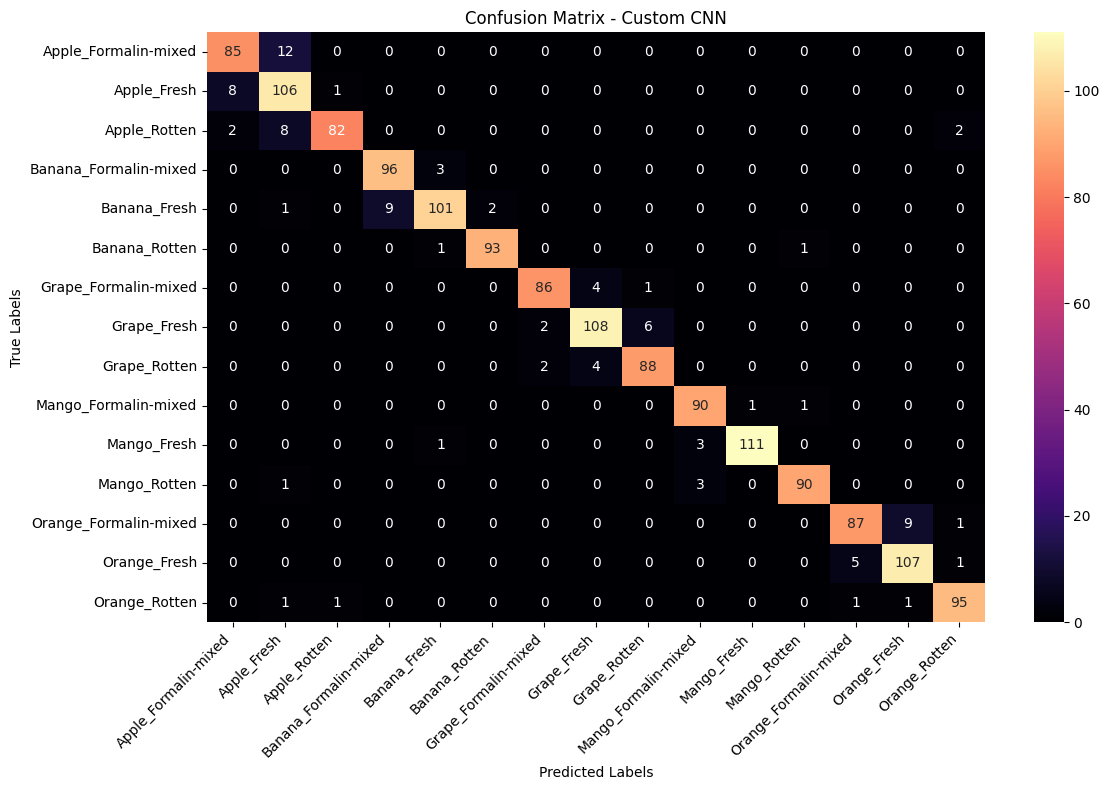

In [34]:

from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt


class_names = [
    "Apple_Formalin-mixed", "Apple_Fresh", "Apple_Rotten",
    "Banana_Formalin-mixed", "Banana_Fresh", "Banana_Rotten",
    "Grape_Formalin-mixed", "Grape_Fresh", "Grape_Rotten",
    "Mango_Formalin-mixed", "Mango_Fresh", "Mango_Rotten",
    "Orange_Formalin-mixed", "Orange_Fresh", "Orange_Rotten"
]


cm = confusion_matrix(y_true, y_pred)


plt.figure(figsize=(12, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="magma", 
            xticklabels=class_names, 
            yticklabels=class_names)

plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix - Custom CNN')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()
